In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import random
import os
import sys
import time
import torch.utils.data as Data
from PIL import Image
from sklearn.model_selection import train_test_split
#data loader, load all the png images in the path loader and save them in a list and return the list as a numpy
def data_loader(path,label):
    data_list = []
    label_list = []
    #search the path and load all the png images
    for file in os.listdir(path):
        if file.endswith(".png"):
            img = Image.open(path + "/"+ file)
            #resize the image to 32*32
            img = img.resize((128,128))
            img = np.array(img)
            data_list.append(img.reshape(128,128,3))
            label_list.append(label)
    #transform the list into a numpy array
    data_list = np.array(data_list)
    label_list = np.array(label_list)
    
    #reshape the numpy array into 2 dimensions
    # data_list = data_list.reshape(data_list.shape[0],1,data_list.shape[1],data_list.shape[2]) 
    return data_list,label_list
data_paper,paper_label=data_loader('../../db/paper',0)
data_rock,rock_label = data_loader('../../db/rock',1)
data_scissor,scissor_label = data_loader('../../db/scissors',2)
data_list = np.concatenate((data_paper,data_rock,data_scissor))
label_list = np.concatenate((paper_label,rock_label,scissor_label))



In [15]:
import tensorflow
data = data_list/255
label= label_list
#split the data into train and test
X_train,X_test,Y_train,Y_test = train_test_split(data,label,test_size=0.2,random_state=42)

# change to one hot encoding
Y_train = tensorflow.keras.utils.to_categorical(Y_train, 3)
Y_test = tensorflow.keras.utils.to_categorical(Y_test, 3)

Use the pretrained Resnet50 to do the transfer learning

In [17]:
 
import os
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense,Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
base_model = ResNet50(weights='imagenet', include_top=False, pooling=None, input_shape=(128, 128, 3),
                    classes=3)
#free most the layers in base_model to get the bottleneck features
for layer in base_model.layers[:len(base_model.layers)-1]:
    layer.trainable = False

x = base_model.output
#add a fully connected layer
x = Flatten()(x)
#x = GlobalAveragePooling2D()(x)
#x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

#train the model
model = Model(inputs=base_model.input, outputs=predictions)
sgd = SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=True,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=True,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=60,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.1,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)
datagen.fit(X_train)

#define the path to save the model
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = "resnet50.h5"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    overwrite=True)

history=model.fit(datagen.flow(X_train,Y_train),
          validation_data=(X_test,Y_test),
          epochs=100,
          callbacks=[model_checkpoint_callback])
 

Epoch 1/100
69/69 [==============================] - 11s 123ms/step - loss: 1.4532 - accuracy: 0.6476 - val_loss: 1.3908 - val_accuracy: 0.3327


C:\Users\yujun\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
69/69 [==============================] - 8s 109ms/step - loss: 0.3967 - accuracy: 0.8686 - val_loss: 1.1696 - val_accuracy: 0.4691
Epoch 3/100
69/69 [==============================] - 8s 114ms/step - loss: 0.3614 - accuracy: 0.8713 - val_loss: 1.3726 - val_accuracy: 0.3473
Epoch 4/100
69/69 [==============================] - 8s 118ms/step - loss: 0.3166 - accuracy: 0.8972 - val_loss: 1.2565 - val_accuracy: 0.5564
Epoch 5/100
69/69 [==============================] - 8s 112ms/step - loss: 0.2627 - accuracy: 0.9113 - val_loss: 0.9801 - val_accuracy: 0.5691
Epoch 6/100
69/69 [==============================] - 8s 112ms/step - loss: 0.2776 - accuracy: 0.9054 - val_loss: 0.9845 - val_accuracy: 0.6018
Epoch 7/100
69/69 [==============================] - 8s 110ms/step - loss: 0.2575 - accuracy: 0.9050 - val_loss: 1.0778 - val_accuracy: 0.3673
Epoch 8/100
69/69 [==============================] - 8s 110ms/step - loss: 0.2460 - accuracy: 0.9113 - val_loss: 1.3395 - val_accuracy: 0.3964

In [18]:
#load the model by using tensorflow
from tensorflow.keras.models import load_model
test_model = load_model('saved_models/resnet50.h5')
print(test_model.evaluate(X_test, Y_test))

18/18 [==============================] - 2s 49ms/step - loss: 0.9102 - accuracy: 0.6600
[0.910237729549408, 0.6600000262260437]


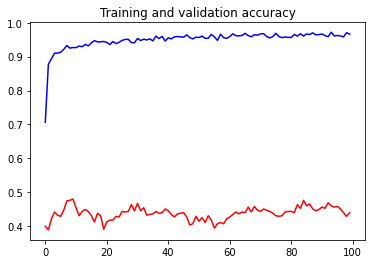

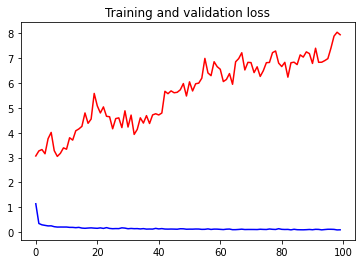

In [ ]:

def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'b-', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.figure()
    plt.plot(epochs, loss, 'b-', label='Training loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    plt.title('Training and validation loss')

plot_training(history)